In [7]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [8]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Run the sampler job locally using FakeManilaV2
#fake_manila = FakeManilaV2()
#pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)

aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)

# To run on hardware, select the backend with the fewest number of jobs in the queue
#service = QiskitRuntimeService(channel="ibm_quantum")
#backend = service.least_busy(operational=True, simulator=False)

In [2]:
import pennylane as qml
from pennylane import numpy as np

In [5]:
H = np.array([[0.5,0.0],[0.0,1.5]]) 

In [6]:
qml.pauli_decompose(H)

1.0 * I(0) + -0.5 * Z(0)

In [9]:
hamiltonian = SparsePauliOp.from_list([("I", 1.0), ("Z", -0.5)])

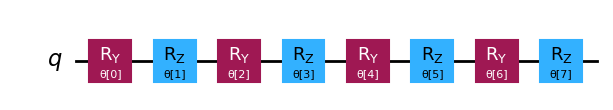

In [10]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

In [11]:
num_params = ansatz.num_parameters
num_params

8

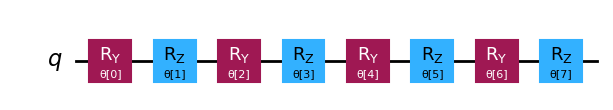

In [12]:
ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [13]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [14]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [15]:
x0 = 2 * np.pi * np.random.random(num_params)

In [16]:
with Session(backend=aer_sim) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: 0.753]
Iters. done: 2 [Current cost: 0.8227]
Iters. done: 3 [Current cost: 0.7050000000000001]
Iters. done: 4 [Current cost: 0.7936]
Iters. done: 5 [Current cost: 1.1668]
Iters. done: 6 [Current cost: 0.7708]
Iters. done: 7 [Current cost: 0.5485]
Iters. done: 8 [Current cost: 0.926]
Iters. done: 9 [Current cost: 0.5515]
Iters. done: 10 [Current cost: 0.7501]
Iters. done: 11 [Current cost: 0.5349999999999999]
Iters. done: 12 [Current cost: 0.6145]
Iters. done: 13 [Current cost: 0.5386]
Iters. done: 14 [Current cost: 0.5343]
Iters. done: 15 [Current cost: 0.5262]
Iters. done: 16 [Current cost: 0.5459]
Iters. done: 17 [Current cost: 0.5871]
Iters. done: 18 [Current cost: 0.525]
Iters. done: 19 [Current cost: 0.6542]
Iters. done: 20 [Current cost: 0.5062]
Iters. done: 21 [Current cost: 0.5116]
Iters. done: 22 [Current cost: 0.5294]
Iters. done: 23 [Current cost: 0.5191]
Iters. done: 24 [Current cost: 0.5089]
Iters. done: 25 [Current cost: 0.5145]
Iters. done: 

In [17]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.5002
       x: [ 3.640e+00  4.418e+00  1.917e+00  2.312e+00  3.123e+00
            1.839e+00  4.523e+00  7.539e-01]
    nfev: 84
   maxcv: 0.0

In [18]:
all(cost_history_dict["prev_vector"] == res.x)

True

In [19]:
cost_history_dict["iters"] == res.nfev

True

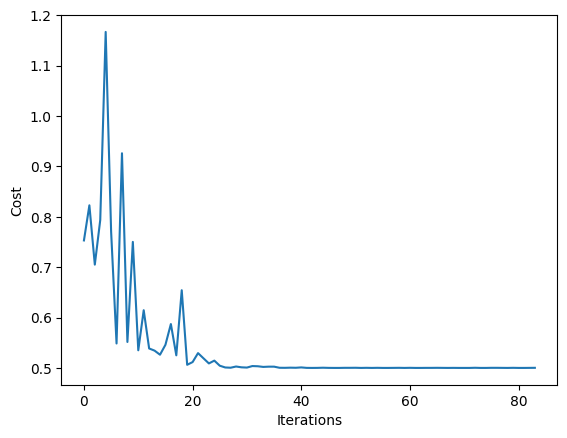

In [20]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()